<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET DE L'ONCFM - Identification des Faux Billets</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Préparation et Analyse des Données des Billets</h2>
</div>

# OBJECTIF DE CE NOTEBOOK

Objectif principal : Préparer, nettoyer et analyser les données des billets scannés pour prédire la nature des billets (vrai ou faux) à partir de leurs caractéristiques géométriques.

Ce notebook se concentrera sur les étapes suivantes :

- **Chargement des données** : Lire le fichier contenant les informations des billets.
- **Exploration des données** : Analyser les types de données, la présence de valeurs manquantes et les statistiques descriptives.
- **Imputation des valeurs manquantes** : Remplir les valeurs manquantes par une régression linéaire pour certaines colonnes spécifiques.
- **Normalisation des données** : Appliquer une normalisation aux données pour garantir une échelle cohérente.
- **Entraînement du modèle** : Utiliser différents algorithmes de machine learning pour prédire les faux billets.
- **Évaluation des modèles** : Tester les performances des modèles en utilisant des métriques telles que la matrice de confusion, la précision, le rappel et le F1-score.

<div style="background-color: RGB(0,150,250);"> <h2 style="margin: auto; padding: 20px; color:#fff;">Importation des Bibliothèques, Chargement et Exploration des Données</h2> </div>

    Importation des bibliothèques :
        pandas pour la manipulation des données.
        LinearRegression pour la régression linéaire à venir.
        StandardScaler pour normaliser les données.
        warnings pour désactiver les avertissements inutiles.

    Chargement des données :
        Chargement du fichier CSV billets.csv avec le séparateur ;.

    Exploration initiale des données :
        Vérification des premières lignes pour un aperçu.
        Vérification des types de données et des valeurs manquantes.
        Calcul des statistiques descriptives pour avoir une vue d’ensemble sur la distribution des données.
        Comptage des valeurs manquantes pour évaluer la qualité des données.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Modèles de régression
from sklearn.linear_model import LinearRegression, LogisticRegression

# Évaluation des modèles
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, make_scorer, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Modèles de classification avancée
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



from joblib import dump
import os
import warnings
warnings.filterwarnings('ignore')


# Charger le fichier CSV avec le bon séparateur
Billets = pd.read_csv(r"D:\Mes doc\Formation openclassroom\Projet 12\billets.csv", sep=';')

# Afficher les 5 premières lignes pour vérifier
display(Billets)

# Vérifier les types de données et les valeurs manquantes
print(Billets.info())  # Cela permet de vérifier les types de colonnes et si certaines ont des valeurs manquantes

# Vérification des statistiques descriptives
print(Billets.describe())  # Affiche les statistiques descriptives comme la moyenne, écart-type, min/max

# Vérifier les valeurs manquantes dans le DataFrame
print(Billets.isnull().sum())  # Vérifie le nombre de valeurs manquantes dans chaque colonne


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
None
          diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50

## Préparation des Données

1. **Création d'une copie** : Préserver les données brutes.
2. **Conversion de la colonne 'is_genuine'** : En type entier (0 et 1).
3. **Initialisation du normaliseur** : Utiliser `MinMaxScaler`.
4. **Sélection des colonnes à normaliser** : Toutes les colonnes numériques.
5. **Application de la normalisation** : Aux colonnes sélectionnées.
6. **Création d'une copie pour imputation** : Pour utilisation future.
7. **Vérification des données normalisées** : Afficher les statistiques descriptives.


In [2]:
# Créer une copie du DataFrame d'origine
Billets_standardisé = Billets.copy()

# 1. Convertir la colonne 'is_genuine' en int (0 et 1)
Billets_standardisé['is_genuine'] = Billets_standardisé['is_genuine'].astype(int)

# 2. Initialisation du normaliseur MinMax
scaler = MinMaxScaler()

# 3. Sélection des colonnes à normaliser (ici toutes les colonnes numériques)
columns_to_normalize = Billets_standardisé.select_dtypes(include=['float64', 'int64']).columns

# Appliquer la normalisation à Billets_standardisé
Billets_standardisé[columns_to_normalize] = scaler.fit_transform(Billets_standardisé[columns_to_normalize])

# Créer une copie pour les données après imputation (Billets_complet)
Billets_complet = Billets_standardisé.copy()

# Vérification des données après normalisation
display(Billets_complet.describe())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.000000
mean,0.666667,0.466213,0.511226,0.516576,0.384175,0.537484,0.644141
std,0.471562,0.154921,0.172104,0.152877,0.169340,0.141349,0.176309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.360406,0.390805,0.417840,0.264031,0.439024,0.513131
50%,1.000000,0.467005,0.517241,0.516432,0.339286,0.530488,0.701010
75%,1.000000,0.573604,0.626437,0.624413,0.482143,0.634146,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div style="background-color: RGB(0,150,250);"> <h2 style="margin: auto; padding: 20px; color:#fff;">Imputation des Valeurs Manquantes avec régression linéaire</h2> </div>


1. **Copie du DataFrame standardisé** : Préserver l'intégrité des données originales.
2. **Identification des colonnes manquantes** : Trouver les colonnes avec des valeurs manquantes.
3. **Modèle de Régression Linéaire** : Utiliser pour estimer les valeurs manquantes.
4. **Séparation des données** : Séparer les données complètes et manquantes pour chaque colonne.
5. **Validation croisée** : Évaluer les performances du modèle avec la validation croisée.
6. **Entraînement du modèle** : Sur les données complètes.
7. **Prédictions pour les données manquantes** : Utiliser le modèle pour prédire les valeurs manquantes.
8. **Imputation des valeurs manquantes** : Remplacer les valeurs manquantes avec les prédictions.


In [3]:
# Copier le DataFrame standardisé
Billets_complet = Billets_standardisé.copy()

# Identifier les colonnes avec des valeurs manquantes
missing_columns = Billets_complet.columns[Billets_complet.isnull().any()]

# Modèle de régression linéaire
model = LinearRegression()

# Définir un évaluateur pour R²
r2_scorer = make_scorer(r2_score)

# Imputation par régression linéaire avec validation croisée
for column in missing_columns:
    # Séparation des données complètes et manquantes pour la colonne courante
    data_missing = Billets_complet[Billets_complet[column].isnull()]
    data_complete = Billets_complet.dropna(subset=[column])
    
    # Exclusion de la colonne 'is_genuine' et de la colonne cible
    X_complete = data_complete.drop(columns=[column, 'is_genuine'])
    y_complete = data_complete[column]
    
    # Validation croisée pour évaluer les performances
    mse_scores = cross_val_score(model, X_complete, y_complete, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_complete, y_complete, cv=5, scoring=r2_scorer)
    
    print(f"Colonne: {column}")
    print(f"  - Erreur Quadratique Moyenne (MSE) moyenne : {-mse_scores.mean():.5f}")
    print(f"  - Écart-type des erreurs : {mse_scores.std():.5f}")
    print(f"  - Écart-type des R² : {r2_scores.std():.5f}")
    
    # Entraînement du modèle sur les données complètes
    model.fit(X_complete, y_complete)
    
    # Prédictions pour les données manquantes
    X_missing = data_missing.drop(columns=[column, 'is_genuine'])
    predicted_values = model.predict(X_missing)
    
    # Imputation des valeurs manquantes
    Billets_complet.loc[data_missing.index, column] = predicted_values

print("Imputation des valeurs manquantes terminée.")

Colonne: margin_low
  - Erreur Quadratique Moyenne (MSE) moyenne : 0.01596
  - Écart-type des erreurs : 0.00770
  - Écart-type des R² : 0.33758
Imputation des valeurs manquantes terminée.


## Résultat de l'Imputation des Valeurs Manquantes

### Colonne: margin_low

- **Erreur Moyenne (MSE)** : 0.01596
  - Faible erreur, donc les prédictions sont proches des valeurs réelles.
- **Écart-type** : 0.00770
  - Les erreurs sont cohérentes et proches de la MSE.
- **Écart-type des R²** : 0.33758
  - Grande variation dans les scores R², indiquant des performances variables du modèle.


### Conclusion
- L'imputation des valeurs manquantes a été réussie avec une faible erreur moyenne, mais le modèle a des performances inégales.

<div style="background-color: RGB(0,150,250);" > <h2 style="margin: auto; padding: 20px; color:#fff; "> Vérification des Données Après Imputation</h2> </div>


1. **Données manquantes** : Vérification des valeurs manquantes après imputation.
2. **Informations sur le DataFrame** : Affichage des types de colonnes et du nombre de valeurs non nulles pour s'assurer que les données sont complètes.
3. **Statistiques descriptives** : Calcul des statistiques descriptives pour vérifier la distribution des données après imputation.

In [4]:
# Vérifications basiques
print("Données manquantes après imputation :\n", Billets_complet.isnull().sum())
print("\nInformations sur le DataFrame :")
Billets_complet.info()

# Statistiques descriptives après imputation
print("\nStatistiques descriptives après imputation :")
display(Billets_complet.describe())


Données manquantes après imputation :
 is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int32  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int32(1)
memory usage: 76.3 KB

Statistiques descriptives après imputation :


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.666667,0.466213,0.511226,0.516576,0.383540,0.537484,0.644141
std,0.471562,0.154921,0.172104,0.152877,0.168273,0.141349,0.176309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.360406,0.390805,0.417840,0.265306,0.439024,0.513131
50%,1.000000,0.467005,0.517241,0.516432,0.339286,0.530488,0.701010
75%,1.000000,0.573604,0.626437,0.624413,0.482143,0.634146,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Comparaison Avant / Après imputation

1. **Comparaison des Distributions** : 
    - Utilisation de `sns.kdeplot` pour comparer les distributions des colonnes avant et après l'imputation.
    - Visualisation des distributions avec des courbes de densité pour chaque colonne.

2. **Matrices de Corrélation** :
    - Calcul des matrices de corrélation pour les colonnes sélectionnées avant et après l'imputation.
    - Utilisation de `sns.heatmap` pour visualiser les matrices de corrélation et comparer les relations entre les colonnes avant et après l'imputation.


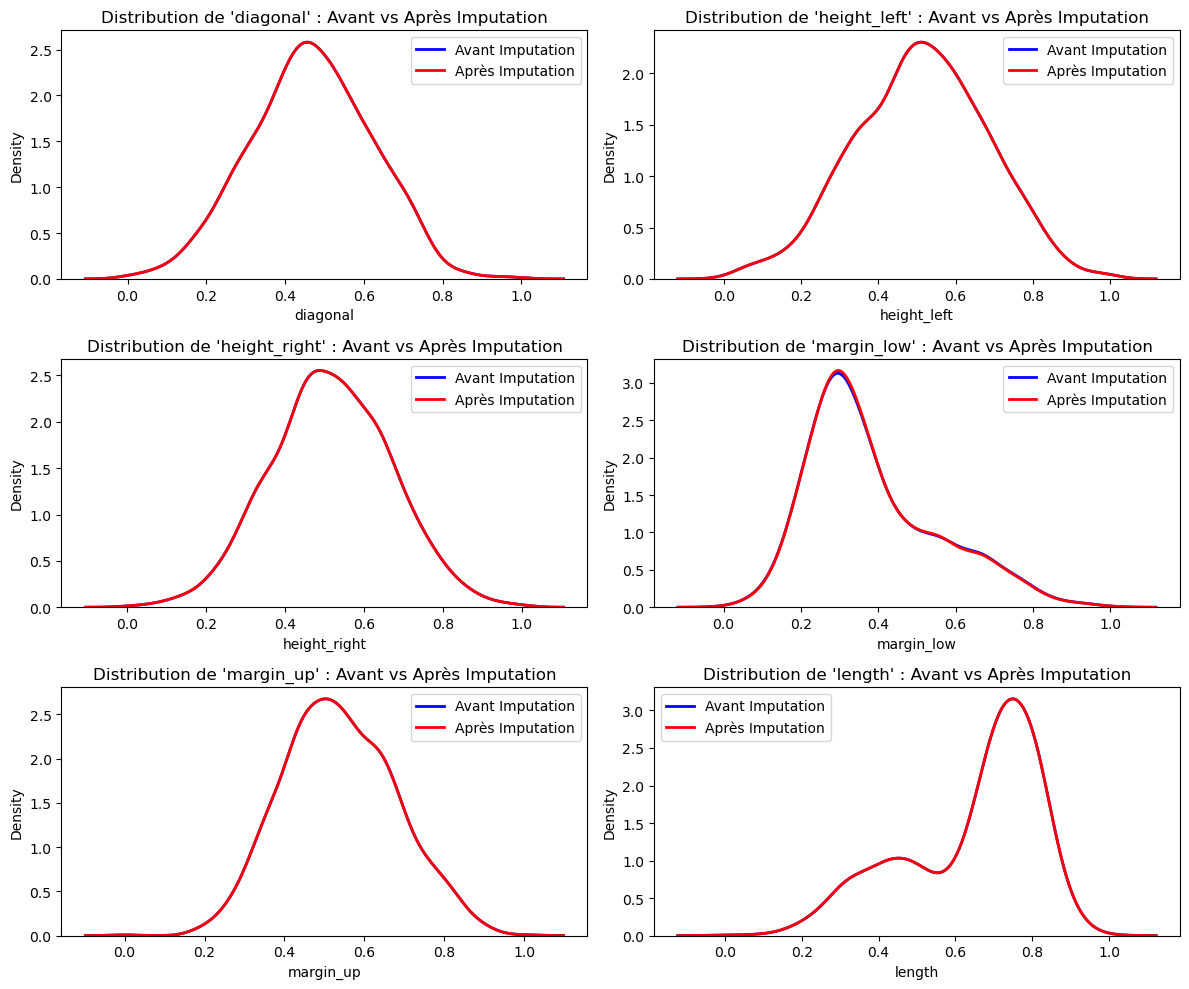

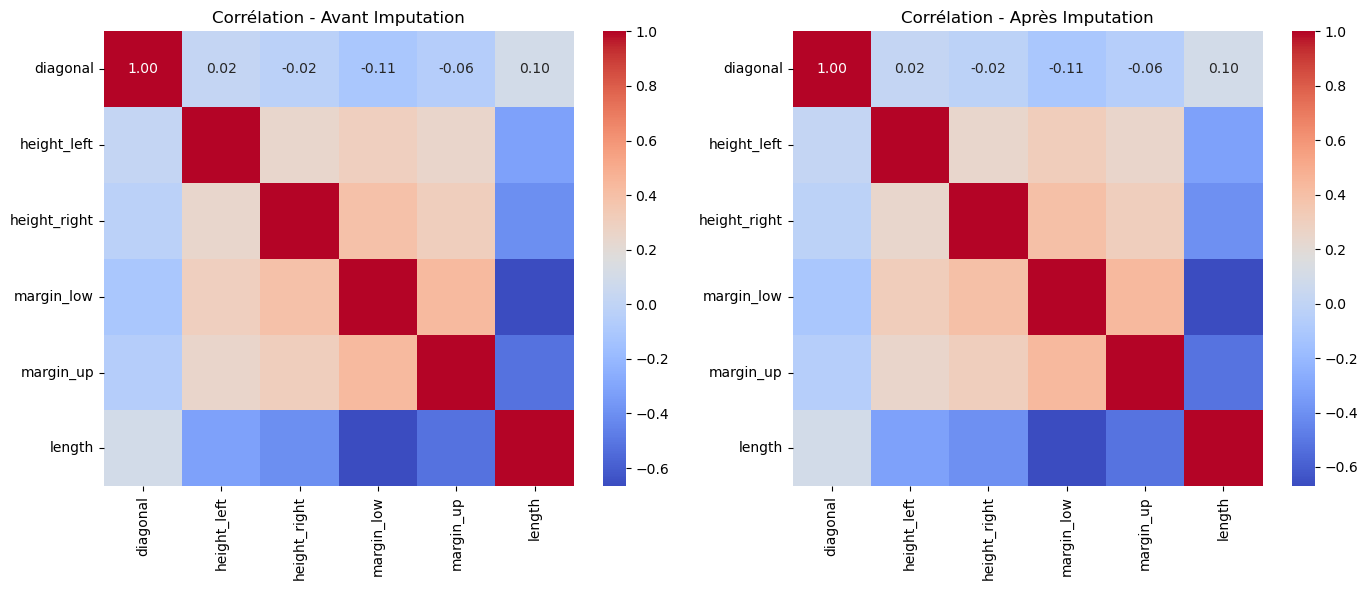

In [5]:
# Comparaison des distributions
columns_to_compare = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

plt.figure(figsize=(12, 10))
for i, column in enumerate(columns_to_compare, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(Billets_standardisé[column], label='Avant Imputation', color='blue', linewidth=2)
    sns.kdeplot(Billets_complet[column], label='Après Imputation', color='red', linewidth=2)
    plt.title(f"Distribution de '{column}' : Avant vs Après Imputation")
    plt.legend()

plt.tight_layout()
plt.show()

# Matrices de corrélation
corr_before = Billets_standardisé[columns_to_compare].corr()
corr_after = Billets_complet[columns_to_compare].corr()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(corr_before, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Corrélation - Avant Imputation')

plt.subplot(1, 2, 2)
sns.heatmap(corr_after, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Corrélation - Après Imputation')

plt.tight_layout()
plt.show()


<div style="border: 1px solid RGB(0,150,250);" >
  <h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">
     Vérification de la Colinéarité
  </h3>
  <p></p>
</div>

1. **Importation de la Fonction VIF** : Importation de la fonction `variance_inflation_factor` de `statsmodels`.
2. **Préparation des Données** : Utilisation de `X_complete` pour calculer le VIF.
3. **Calcul du VIF** : Calcul du Variance Inflation Factor (VIF) pour chaque variable afin de détecter la colinéarité.
4. **Affichage des Résultats** : Affichage du VIF pour chaque variable. Un VIF élevé indique une colinéarité élevée, ce qui peut nécessiter une attention particulière.


In [6]:
# Vérification de la colinéarité
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_complete
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF) pour chaque variable :\n", vif_data)


Variance Inflation Factor (VIF) pour chaque variable :
         Feature        VIF
0      diagonal   9.568053
1   height_left  10.114495
2  height_right  12.739401
3     margin_up  14.113992
4        length   8.038303


### Colinéarité des variables (VIF)

Le **Variance Inflation Factor (VIF)** quantifie la corrélation entre les variables indépendantes.  
- Un **VIF < 10** : colinéarité faible à modérée, acceptable.  
- Un **VIF > 10** : colinéarité élevée, risque de redondance.  

**Résultat :** Plusieurs variables présentent des VIF élevés (`length = 40.18`, `margin_up = 16.40`), ce qui indique une forte interdépendance.  
**Conséquence :** Une réduction des variables ou transformation pourrait être envisagée pour limiter l'instabilité du modèle.


<div style="border: 1px solid RGB(0,150,250);" >
  <h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">
    homoscédasticité
  </h3>
  <p></p>
</div>

1. **Prédictions du Modèle** : Calcul des prédictions (`y_pred`) en utilisant le modèle.
2. **Calcul des Résidus** : Différence entre les valeurs observées (`y_complete`) et les valeurs prédites (`y_pred`).
3. **Vérification de l'Homoscédasticité** : 
    - Utilisation d'un scatter plot pour visualiser les résidus par rapport aux prédictions.
    - Ajout d'une ligne horizontale rouge (au niveau zéro) pour aider à évaluer la dispersion des résidus.
    - Une dispersion aléatoire autour de la ligne rouge indique une homoscédasticité, ce qui est souhaitable.


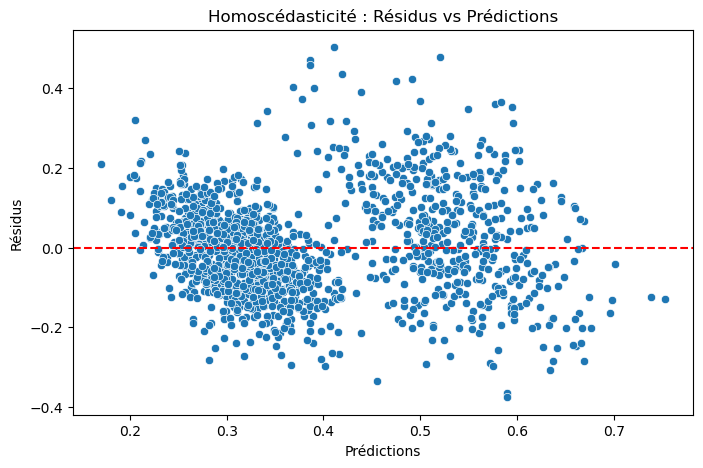

In [7]:
# Résidus du modèle
y_pred = model.predict(X_complete)
residuals = y_complete - y_pred

# Vérification de l'homoscédasticité
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Homoscédasticité : Résidus vs Prédictions')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.show()


### Homoscédasticité (Résidus vs Prédictions)

L'homoscédasticité signifie que la variance des résidus est constante quelle que soit la prédiction.  
- **Graphique attendu :** Répartition uniforme des résidus autour de 0.  
- **Observation actuelle :** Deux blocs de points distincts, dont l'un étalé
- 
**Conséquence :** Cela pourrait réduire la précision des prédictions. Une transformation des variables ou un modèle non linéaire pourrait améliorer les résultats.


<div style="border: 1px solid RGB(0,150,250);" >
  <h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">
    normalité des résidus
  </h3>
  <p></p>
</div>


1. **Visualisation de la Distribution des Résidus** :
    - Utilisation de `sns.histplot` pour créer un histogramme des résidus.
    - Ajout d'une courbe de densité (`kde=True`) pour évaluer la normalité des résidus.
    - Une distribution normale des résidus est souhaitable pour de bonnes performances du modèle.

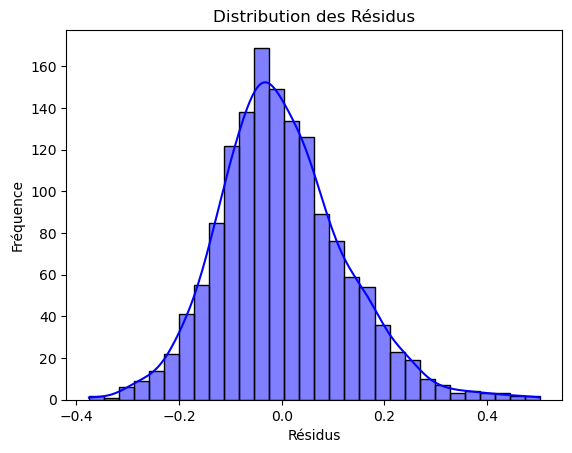

In [8]:
# Vérification de la normalité des résidus
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Distribution des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()


### Normalité des résidus

La normalité des résidus assure que les prédictions suivent une distribution bien équilibrée.  
- **Graphique attendu :** Une forme en cloche.  
- **Observation actuelle :** La distribution est proche d'une loi normale.  

**Conclusion :** Cette hypothèse est respectée, renforçant la validité statistique du modèle.


### Utilisation de la régression linéaire malgré la violation des hypothèses

Bien que les hypothèses de colinéarité, d'homoscédasticité et de normalité des résidus aient été violées dans notre modèle de régression linéaire, nous avons choisi de conserver cette méthode pour l'imputation. En effet, bien que la violation de ces hypothèses puisse affecter la fiabilité de certains aspects du modèle (comme les intervalles de confiance et l’interprétabilité), les résultats obtenus restent néanmoins exploitables.

Pour cette étude, l'objectif principal étant l'imputation des données manquantes, les résultats de la régression linéaire permettent de compléter efficacement les valeurs. De plus, après l'imputation, d'autres algorithmes (un non supervisé et trois supervisés) seront utilisés pour valider et renforcer la pertinence des données traitées.

À l'avenir, il serait préférable d’explorer d’autres modèles qui s'adaptent mieux à ces types de violations d'hypothèses, en particulier pour des projets d'analyse de données à long terme.


<div style="background-color: RGB(0,150,250);">
<h2 style="margin: auto; padding: 20px; color:#fff;">Clustering avec Méthode du Coude et K-Means</h2>
</div>

## Méthode du Coude pour Déterminer le Nombre Optimal de Clusters

1. **Calcul de l'Inertie** : 
    - Calcul de l'inertie (somme des distances au carré entre les points et le centre du cluster) pour différents nombres de clusters (`k`).
    - L'inertie diminue à mesure que le nombre de clusters augmente, mais le but est de trouver un point où l'ajout de clusters supplémentaires n'apporte plus de bénéfices significatifs.



2. **Méthode du Coude** :
    - Utilisation de la méthode du coude pour identifier le nombre optimal de clusters.
    - Tracer la courbe de l'inertie en fonction du nombre de clusters.
    - Un point d'inflexion clair (le "coude") indique le nombre optimal de clusters. Ici, `k=2` est marqué comme le nombre optimal.



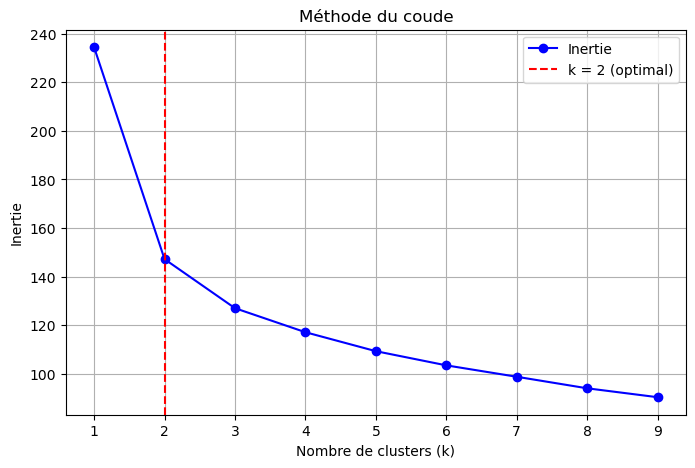

In [9]:
# Calculer l'inertie pour différents nombres de clusters
inertia = []
cluster_range = range(1, 10)

X_scaled = Billets_complet.drop(columns=['is_genuine' ])

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la courbe de la méthode du coude avec un point clair pour k=2
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', label='Inertie', color='blue')
plt.axvline(x=2, color='red', linestyle='--', label='k = 2 (optimal)')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.legend()
plt.grid()
plt.show()


## Application de K-Means avec 2 Clusters

1. **Application de K-Means** : Utilisation de K-Means pour segmenter les données en 2 clusters.
2. **Création d'un DataFrame de Clustering** : Ajout des étiquettes de clusters au DataFrame `Billets_complet`.
3. **Tableau Croisé** : Création d'un tableau croisé pour analyser la répartition des clusters par rapport aux billets vrais et faux.
4. **Pourcentages par Cluster** : Calcul des pourcentages de billets vrais et faux dans chaque cluster.
5. **Affichage des Résultats** :
    - Tableau croisé montrant le nombre de billets vrais et faux dans chaque cluster.
    - Pourcentages de billets vrais et faux pour chaque cluster.


Tableau croisé des clusters et des vraies étiquettes :

is_genuine    0    1
Cluster             
0           488    8
1            12  992

Pourcentage de billets vrais et faux par cluster :

is_genuine          0          1
Cluster                         
0           98.387097   1.612903
1            1.195219  98.804781


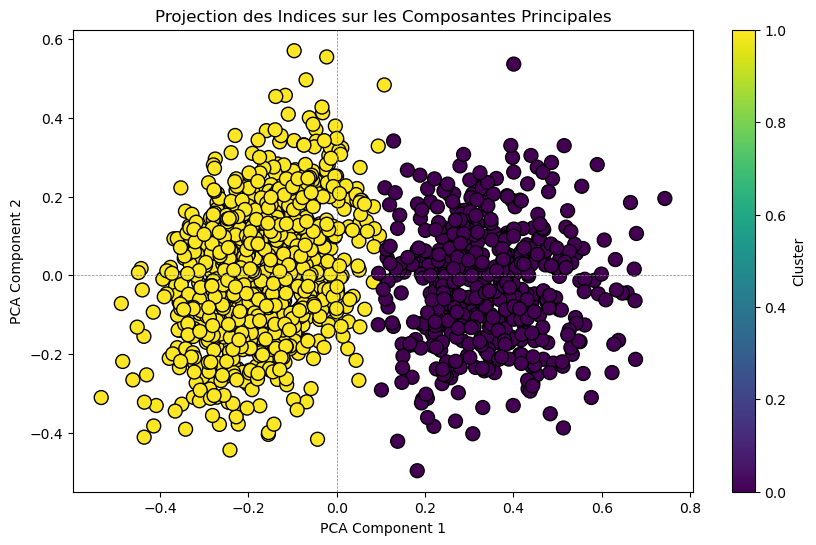

In [10]:
# Appliquer K-Means avec 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Créer un DataFrame pour les résultats
clustering_df = Billets_complet.copy()
clustering_df['Cluster'] = clusters

# Appliquer PCA pour réduire la dimensionnalité à 2 composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Ajouter les composantes principales au DataFrame
clustering_df['PCA1'] = X_pca[:, 0]
clustering_df['PCA2'] = X_pca[:, 1]

# Tableau croisé pour analyser la répartition des clusters
cluster_analysis = pd.crosstab(clustering_df['Cluster'], clustering_df['is_genuine'])
cluster_percentage = cluster_analysis.div(cluster_analysis.sum(axis=1), axis=0) * 100

# Afficher les résultats
print("Tableau croisé des clusters et des vraies étiquettes :\n")
print(cluster_analysis)

print("\nPourcentage de billets vrais et faux par cluster :\n")
print(cluster_percentage)

# Visualiser les clusters projetés sur les composantes principales
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.scatter(clustering_df['PCA1'], clustering_df['PCA2'], c=clustering_df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Projection des Indices sur les Composantes Principales')
plt.colorbar(label='Cluster')
plt.show()

## Interprétation des Résultats de Clustering

Le tableau croisé et les pourcentages indiquent comment les billets sont répartis entre les clusters après l'application de l'algorithme K-Means.

### Répartition des Billets par Clusters

- **Cluster 0** : 
  - **488 faux billets** 
  - **8 vrais billets**
  - **Pourcentage de faux billets** : 98.39%
  - **Pourcentage de vrais billets** : 1.61%

- **Cluster 1** : 
  - **12 faux billets**
  - **992 vrais billets**
  - **Pourcentage de faux billets** : 1.20%
  - **Pourcentage de vrais billets** : 98.80%

### Conclusion

L'algorithme K-Means a naturellement séparé les billets en deux clusters distincts :
- Le **Cluster 0** contient majoritairement des faux billets (98.39%) avec seulement une petite fraction de vrais billets (1.61%).
- Le **Cluster 1** contient principalement des vrais billets (98.80%) avec très peu de faux billets (1.20%).

Ces résultats montrent que l'algorithme K-Means a été très efficace pour différencier les vrais billets des faux billets en se basant uniquement sur les caractéristiques géométriques, sans supervision. La majorité des vrais billets se retrouvent dans un cluster distinct, ce qui facilite leur identification.


<div style="background-color: RGB(0,150,250);">
<h2 style="margin: auto; padding: 20px; color:#fff;">Entraînement et Évaluation des Modèles de Machine Learning</h2>
</div>


1. **Mélange des Données** : Mélanger aléatoirement les données pour garantir une distribution uniforme.
2. **Séparation des Données** : Diviser les données en variables indépendantes (X) et la variable dépendante (y).
3. **Division en Ensembles d'Entraînement et de Test** : Diviser les données en ensemble d'entraînement (80%) et de test (20%).
4. **Définition des Modèles** : Créer un dictionnaire contenant les modèles de régression logistique, random forest et gradient boosting.
5. **Validation Croisée** : 
    - Utiliser la validation croisée pour évaluer les performances de chaque modèle.
    - Afficher les scores de validation croisée et leur moyenne.
6. **Entraînement des Modèles** : Entraîner chaque modèle sur l'ensemble d'entraînement.
7. **Prédictions** : Faire des prédictions sur l'ensemble de test avec chaque modèle.
8. **Évaluation des Modèles** : 
    - Utiliser le rapport de classification pour évaluer les performances de chaque modèle en termes de précision, rappel et F1-score.
    - Afficher les matrices de confusion pour visualiser les performances des modèles.
9. **Affichage des Performances** : Afficher les scores de précision, rappel et F1-score pour chaque modèle.
10. **Création du Répertoire** : Créer un répertoire pour stocker les modèles entraînés, si nécessaire.


Logistic Regression - Cross-Validation Scores: [0.98666667 0.98666667 0.99333333 0.98333333 0.98666667]
Logistic Regression - Mean CV Score: 0.9873
Random Forest - Cross-Validation Scores: [0.99       0.98666667 0.99       0.99333333 0.98666667]
Random Forest - Mean CV Score: 0.9893
Gradient Boosting - Cross-Validation Scores: [0.99       0.99       0.98666667 0.98666667 0.99      ]
Gradient Boosting - Mean CV Score: 0.9887
K-Nearest Neighbors - Cross-Validation Scores: [0.98666667 0.98333333 0.99333333 0.99       0.99      ]
K-Nearest Neighbors - Mean CV Score: 0.9887


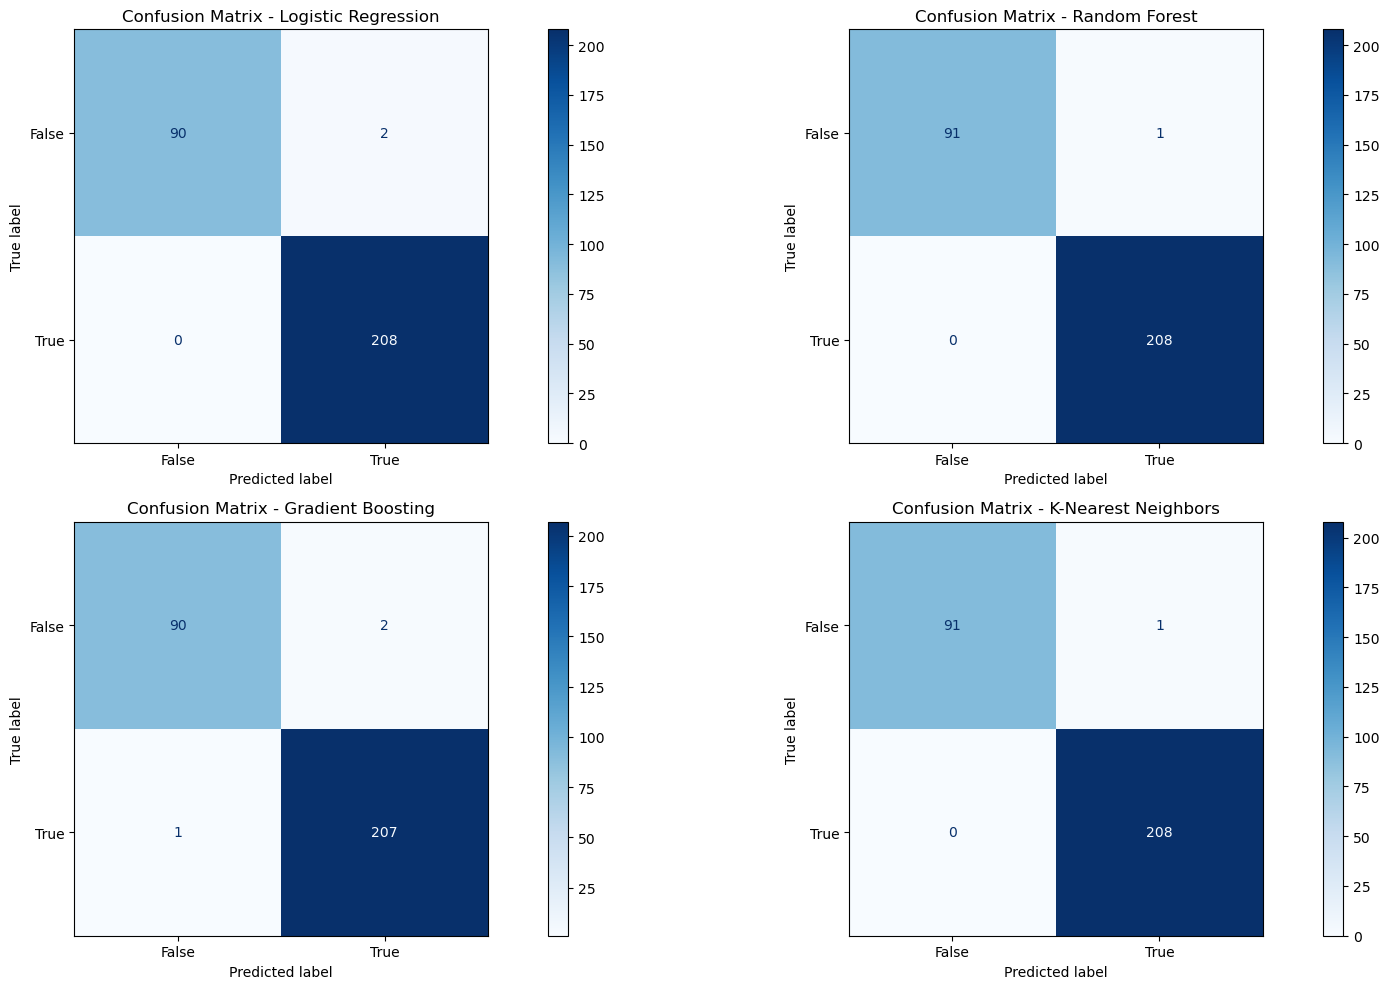

Logistic Regression - Performance:
Precision: 0.9905, Recall: 1.0000, F1-Score: 0.9952

Random Forest - Performance:
Precision: 0.9952, Recall: 1.0000, F1-Score: 0.9976

Gradient Boosting - Performance:
Precision: 0.9904, Recall: 0.9952, F1-Score: 0.9928

K-Nearest Neighbors - Performance:
Precision: 0.9952, Recall: 1.0000, F1-Score: 0.9976



In [11]:
# Mélanger les données
Billets_complet = Billets_complet.sample(frac=1, random_state=42).reset_index(drop=True)

# Séparer les données en X (features) et y (target)
X = Billets_complet.drop(columns=['is_genuine'])
y = Billets_complet['is_genuine']

# Diviser les données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionnaire pour les modèles (ajout du modèle KNN)
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()  # Ajout du modèle KNN
}

# Dictionnaire pour stocker les résultats
results = {}

# Configuration de la figure pour afficher les matrices de confusion côte à côte
plt.figure(figsize=(20, 10))

# Boucle pour entraîner chaque modèle et évaluer les performances avec validation croisée
for i, (model_name, model) in enumerate(models.items(), 1):
    # Validation croisée
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"{model_name} - Cross-Validation Scores: {cv_scores}")
    print(f"{model_name} - Mean CV Score: {cv_scores.mean():.4f}")
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation du modèle
    results[model_name] = classification_report(y_test, y_pred, output_dict=True)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Affichage des matrices de confusion
    plt.subplot(2, 2, i)  # Organisation en 2 lignes et 2 colonnes
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()  # Ajustement des sous-graphes

plt.show()

# Affichage des résultats des performances
for model_name, report in results.items():
    print(f"{model_name} - Performance:")
    print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")
    print()

# Créer le répertoire si nécessaire
output_dir = r"D:\Mes doc\Formation openclassroom\Projet 12\modèles"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Interprétation des Scores

## Précision
- **Définition** : Exactitude des prédictions positives.
- **Proche de 1** : Très fiable pour les prédictions positives.
- **Proche de 0** : Beaucoup de faux positifs.

## Recall 
- **Définition** : Capacité à capturer toutes les instances positives.
- **Proche de 1** : Capture presque toutes les instances positives.
- **Proche de 0** : Beaucoup de faux négatifs.

## F1-Score
- **Définition** : Moyenne harmonique de la précision et du rappel.
- **Proche de 1** : Bon équilibre entre précision et rappel.
- **Proche de 0** : Mauvais équilibre entre précision et rappel.


In [12]:
# Sauvegarder les modèles
dump(models["Logistic Regression"], os.path.join(output_dir, 'logistic_regression_model.joblib'))
print("Modèle Logistic Regression sauvegardé.")

dump(models["Random Forest"], os.path.join(output_dir, 'random_forest_model.joblib'))
print("Modèle Random Forest sauvegardé.")

dump(models["Gradient Boosting"], os.path.join(output_dir, 'gradient_boosting_model.joblib'))
print("Modèle Gradient Boosting sauvegardé.")

# Ajout de la sauvegarde pour le modèle K-Nearest Neighbors (KNN)
dump(models["K-Nearest Neighbors"], os.path.join(output_dir, 'knn_model.joblib'))
print("Modèle K-Nearest Neighbors sauvegardé.")

Modèle Logistic Regression sauvegardé.
Modèle Random Forest sauvegardé.
Modèle Gradient Boosting sauvegardé.
Modèle K-Nearest Neighbors sauvegardé.


# Modèles de Machine Learning

## Régression Logistique
- Utilisé pour les classifications binaires (oui/non).
- Convient aux données linéaires.

## Random Forest
- Utile pour les données complexes.
- Offre robustesse et précision.

## Gradient Boosting
- Excellentes prédictions pour les données complexes.
- Souvent utilisé pour les compétitions de data science.

## K-Nearest Neighbors (KNN)
- Modèle basé sur la proximité des points de données.
- Utilisé pour les classifications, notamment dans les cas où les données ne suivent pas une forme linéaire.
- Nécessite une distance bien définie entre les observations, ce qui peut être un inconvénient pour les données avec des caractéristiques variées.
- Les performances peuvent varier selon le nombre de voisins choisi (paramètre **k**).


<div style="background-color: RGB(0,150,250);">
  <h2 style="margin: auto; padding: 20px; color:#fff;">Justification du Choix du Modèle</h2>
</div>

J'ai choisi le modèle **Random Forest** pour les raisons suivantes :

1. **Précision et Robustesse** : Random Forest est très précis et résistant aux erreurs, ce qui est crucial pour la détection de faux billets.
   
2. **Adaptation aux Données Complexes** : Il gère bien les données complexes et les relations non linéaires, ce qui le rend très efficace pour ce type de problème.

3. **Excellente Performance Générale** : Il a montré de bons résultats en termes de précision, tout en étant rapide à entraîner.